<a href="https://colab.research.google.com/github/alanci2003/PUBH6859/blob/main/HLT_Assignment4_PubMed_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PubMed Visualization
This notebook will help you to visualize the sample output of searches trough the PubMed database.  
  
## Data format
To prepare the data:  
1. place all the data files in a directory with the following name foramt:  **GROUPNAME(underline)SUBGROUPNAME.csv**. As an example: Adiposity_GC-MS.csv shows the results from *Adiposity* with GC-MS as the thechnology.
2. replace the directory name with the _dat_directory_ argument in the **data_prep** function (It's default value is _pubmed_data_)

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import datetime
from Bio import Entrez

In [75]:
def fetch_pubmed_data(search_query):
    Entrez.email = "hltiunn@gwu.edu"  # Your email goes here
    handle = Entrez.esearch(db="pubmed", term=search_query, retmax=10000, usehistory="y")
    record = Entrez.read(handle)
    handle.close()

    if int(record["Count"]) == 0:  # Check for empty results
        return {}

    webenv = record["WebEnv"]
    query_key = record["QueryKey"]
    count = int(record["Count"])

    handle = Entrez.esummary(db="pubmed", webenv=webenv, query_key=query_key, retmax=count)
    summary_records = Entrez.read(handle)
    handle.close()

    year_counts = {}
    for summary in summary_records:
        pub_year = summary.get('PubDate', '').split()[0]  # Extract the year
        if pub_year.isdigit():
            year_counts[pub_year] = year_counts.get(pub_year, 0) + 1

    return year_counts

def main():
    diseases = ["PCOS", "SLE", "ALS", "SCA", "Atopic dermatitis", "Irritable bowel syndrome"]  # List of diseases
    technologies = ["NMR", "GC-MS", "LC-MS", "CE-MS"]  # List of technologies

    for disease in diseases:
        for tech in technologies:
            search_query = f'("{disease}" AND ("metabolom*" AND "{tech})")'
            result = fetch_pubmed_data(search_query)
            if result:
                df = pd.DataFrame(list(result.items()), columns=['Year', 'Count'])
                df = df.sort_values('Year')

                # Filename for each disease-technology combination
                filename = f"{disease.replace(' ', '')}_{tech}.csv"
                output_path = "/content/drive/My Drive/PubH6859/Assignment 4/data"
                df.to_csv(f"{output_path}/{filename}", index=False)
                print(f"Data saved to {filename}")
            else:
                print(f"No data found for {disease} with {tech}")

if __name__ == "__main__":
    main()

Data saved to PCOS_NMR.csv
Data saved to PCOS_GC-MS.csv
Data saved to PCOS_LC-MS.csv
No data found for PCOS with CE-MS
Data saved to SLE_NMR.csv
Data saved to SLE_GC-MS.csv
Data saved to SLE_LC-MS.csv
No data found for SLE with CE-MS
Data saved to ALS_NMR.csv
Data saved to ALS_GC-MS.csv
Data saved to ALS_LC-MS.csv
Data saved to ALS_CE-MS.csv
Data saved to SCA_NMR.csv
No data found for SCA with GC-MS
Data saved to SCA_LC-MS.csv
No data found for SCA with CE-MS
Data saved to Atopicdermatitis_NMR.csv
Data saved to Atopicdermatitis_GC-MS.csv
Data saved to Atopicdermatitis_LC-MS.csv
No data found for Atopic dermatitis with CE-MS
Data saved to Irritablebowelsyndrome_NMR.csv
Data saved to Irritablebowelsyndrome_GC-MS.csv
Data saved to Irritablebowelsyndrome_LC-MS.csv
No data found for Irritable bowel syndrome with CE-MS


In [76]:
def data_prep(dat_directory='/content/drive/My Drive/PubH6859/Assignment 4/data'):
    cn = 0
    df = pd.DataFrame()

    # Check if the directory exists
    if not os.path.exists(dat_directory):
        print(f"Directory not found: {dat_directory}")
        return df  # Return an empty DataFrame if the directory doesn't exist

    for file in os.listdir(dat_directory):
        file_path = os.path.join(dat_directory, file)  # Use os.path.join for proper path handling
        try:
            temp = pd.read_csv(file_path, skiprows=1, sep=',')
            if temp.empty:
                print(f"Skipping empty file: {file}")
                continue

            # Check file name structure and adjust accordingly
            file_parts = file.split('_')
            if len(file_parts) < 2:
                print(f"Filename format incorrect for file: {file}")
                continue  # Skip files that do not match expected naming format

            # Extract 'omics' and 'tech' from the file name
            omics = file_parts[0]
            tech = file_parts[-1].split('.')[0]  # Splits on dot and takes the first part to remove extension

            temp['omics'] = omics  # Add 'omics' column
            temp['tech'] = tech   # Add 'tech' column
            temp.columns = ['year', 'count', 'omics', 'tech']

            if cn == 0:
                df = temp.copy()
            else:
                df = pd.concat([df, temp], ignore_index=True)
            cn += 1

        except Exception as e:
            print(f"Error processing file {file}: {e}")

    if cn == 0:
        print("No files processed. Please check the directory and file types.")

    return df


In [77]:
def ncolors(n, colormap='cividis', custom_palette=None):
    """
    Utility for defining N evenly spaced colors across a color map or custom palette.
    :param n: number of colors to generate
    :param colormap: name of colormap to use (default: 'cividis')
    :param custom_palette: custom list of colors to use (default: None)
    :return: list of N colors
    """
    if custom_palette is not None:
        return custom_palette[:n]
    else:
        cmap = plt.get_cmap(colormap)
        cmap_max = cmap.N
        return [cmap(int(k * cmap_max / (n - 1))) for k in range(n)]

Skipping empty file: SpinocerebellarAtaxia_NMR.csv.csv


<Figure size 640x480 with 0 Axes>

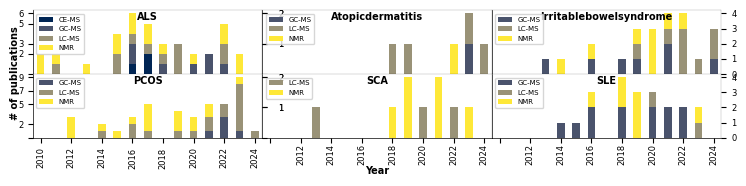

In [78]:
drive_path =  '/content/drive/My Drive/PubH6859/Assignment 4'

px = []
cn = 0
df_main = data_prep(dat_directory= drive_path + '/data')
name_list = list(set(df_main.loc[:, 'omics']))
name_list.sort()
min_year = df_main.loc[:, 'year'].min()
max_year = df_main.loc[:, 'year'].max()
temp_0 = pd.DataFrame(range(min_year, max_year+1), columns=['year'])
tech_list = list(df_main.loc[:, 'tech'])
tech_list.sort()
colors = ncolors(len(tech_list))
color_pal = {}
for n, tech in enumerate(tech_list):
  color_pal[tech] = colors[n]

fig=plt.figure()
fig = plt.figure(figsize=(7.2,1.6))
gs=GridSpec(4,6,wspace=0.0,hspace = 0.0)

for i in [0,2]:
    for j in [0,2,4]:
        temp = df_main.loc[df_main.loc[:, 'omics'] == name_list[cn], :]
        temp = pd.pivot_table(data=temp,
                              index=['year'],
                              columns=['tech'],
                              values='count').reset_index()
        df = temp_0.merge(temp, how = 'left')
        df.fillna(0, inplace=True)


        px.append(fig.add_subplot(gs[i:(i+2), j:(j+2)]))
        px[-1].tick_params(axis='both', which='major', labelsize=6)

        try:
            df.plot(x='year', kind='bar',
                    stacked = True, color= color_pal, ax = px[-1])
        except:
            pass
        plt.xlabel("")
        ymin, ymax = px[-1].get_ylim()

        px[-1].set_yticks(np.round(np.linspace(ymin, ymax, 5), 0))
        px[-1].xaxis.set_tick_params(labelsize=6)
        px[-1].spines['top'].set_linewidth(0.1)
        px[-1].spines['left'].set_linewidth(0.5)
        px[-1].spines['right'].set_linewidth(0.1)
        px[-1].spines['bottom'].set_linewidth(0.5)
        px[-1].legend(loc ='upper left', fontsize = 5)

        if cn in [1, 4]:
            px[-1].tick_params(axis="y",direction="in", pad=-15)
        if cn in [2, 5]:
            px[-1].yaxis.tick_right()
        if cn <3:
            px[-1].yaxis.get_major_ticks()[0].label1.set_visible(False)
            px[-1].set_xticklabels([])
        else:
            px[-1].yaxis.get_major_ticks()[0].label1.set_visible(False)
            px[-1].set_xticks(px[-1].get_xticks()[::2])
            px[-1].xaxis.label.set_visible(False)
            if cn > 3:
                px[-1].xaxis.get_major_ticks()[0].label1.set_visible(False)
                px[-1].tick_params(axis="x",direction="out", pad=1)



        px[-1].xaxis.set_tick_params(labelsize=6)#COunt
        px[-1].yaxis.set_tick_params(labelsize=6)#Year


        px[-1].text(.5, .85, name_list[cn], transform=px[-1].transAxes, ha="center", weight='bold', size =7)
        cn += 1
fig.text(0.5, -0.03, 'Year', ha='center', fontsize = 7, weight='bold')
fig.text(-0.01, 0.6, '# of publications', va='center', rotation='vertical', fontsize = 7, weight='bold')
plt.tight_layout(pad=0.05)

fig.savefig(drive_path+"/supp1.pdf", dpi=600, bbox_inches = "tight")
fig.savefig(drive_path+"/supp1.png", dpi=600, bbox_inches = "tight")
plt.show()